# Special SNP-only absolute risk model

In this example, we will demonstrate the use of iCARE's special SNP option that allows you to specify a SNP-based absolute risk model without the need to provide a reference dataset to represent the risk factor distribution of the underlying population. If a reference dataset for the SNPs is available, please use the regular covariate-only model instead because it makes fewer assumptions about the underlying population risk factor distribution.

Specifically, we will use iCARE to build and apply absolute risk models of breast cancer using known associated 72 SNPs from literature.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import icare


# Set the plot background to white
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "white"})

To specify a SNP-only model using the special option, we must input the file containing the marginal age-specific incidence rates of breast cancer (`model_competing_incidence_rates_path`), and the SNP information (`model_snp_info_path`), that has three columns named: (`snp_name`, `snp_odds_ratio`, and `snp_freq` corresponding to the SNP name, their odds ratios in association with breast cancer risk, and their minor allele frequencies, respectively). Marginal age-specific incidence rates of competing risks (`model_competing_incidence_rates_path`) are optional. We include them in this example.

In [2]:
model_disease_incidence_rates_path = "../data/age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_path = "../data/age_specific_all_cause_mortality_rates.csv"
model_snp_info_path = "../data/breast_cancer_72_snps_info.csv"

Here, `breast_cancer_72_snps_info.csv` contains published information on the odds-ratios and allele frequencies of 72 SNPs identified, among a larger set of markers, to be associated with breast cancer risk by [a recent genome-wide association study](https://www.nature.com/articles/nature24284) (Michailidou et al., 2017). `age_specific_breast_cancer_incidence_rates.csv` contains age-specific incidence rates of breast cancer from [Surveillance, Epidemiology and End Results (SEER) Program](https://seer.cancer.gov/), and `age_specific_all_cause_mortality_rates.csv` has age-specific incidence rates of all-cause mortality from [the CDC WONDER database](https://wonder.cdc.gov/).

In fitting a SNP-only model using the special option, the reference dataset need not be provided as iCARE will impute the reference SNP distribution based on SNP allele frequencies. The function call below builds an absolute risk model based on 72 SNPs for breast cancer and applies the model to estimate risk of breast cancer in the interval from age 50 to 80:

In [3]:
results = icare.compute_absolute_risk(
    apply_age_start=50,
    apply_age_interval_length=30, # 50 + 30 = 80
    model_disease_incidence_rates_path=model_disease_incidence_rates_path,
    model_competing_incidence_rates_path=model_competing_incidence_rates_path,
    model_snp_info_path=model_snp_info_path,
    return_reference_risks=True # return the absolute risks for the simulated reference population
)


Note: You included 'model_snp_info' but did not provide an 'apply_snp_profile_path'. iCARE will impute SNPs for 10000 individuals. If you require more, please provide an input to 'apply_snp_profile_path' input.


Note: You did not provide a 'model_family_history_variable_name', therefore the model will not adjust the SNP imputations for family history.



The method returns a dictionary containing the following keys:

In [4]:
results.keys()

dict_keys(['model', 'profile', 'reference_risks'])

The `model` key contains the absolute risk model parameters, i.e., the odds-ratios for each SNP in association with breast cancer risk:

In [5]:
model = pd.Series(results["model"])
model

rs616488     -0.061875
rs11552449    0.039221
rs11249433    0.104360
rs12405132   -0.030459
rs12048493    0.039221
                ...   
rs2284378     0.000000
rs2823093    -0.061875
rs17879961    0.231112
rs132390      0.039221
rs6001930     0.113329
Length: 72, dtype: float64

Since no profiles were input, iCARE creates 10,000 profiles with the 72 SNPs but with all SNP values missing, as shown below:

In [6]:
profiles = pd.read_json(results["profile"], orient="records")
profiles.head()

,id,age_interval_start,age_interval_end,risk_estimates,rs616488,rs11552449,rs11249433,rs12405132,rs12048493,rs6678914,...,rs527616,rs1436904,rs6507583,rs4808801,rs3760982,rs2284378,rs2823093,rs17879961,rs132390,rs6001930
0,0,50,80,0.096006,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,50,80,0.096006,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,50,80,0.096006,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,50,80,0.096006,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,50,80,0.096006,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that since all SNPs were missing, iCARE assigns each of their risks equal to the mean of the risks of the reference population:

In [7]:
profiles["risk_estimates"].describe().apply(lambda x: format(x, 'f'))

count    10000.000000
mean         0.096006
std          0.000000
min          0.096006
25%          0.096006
50%          0.096006
75%          0.096006
max          0.096006
Name: risk_estimates, dtype: object

We can calculate the summary statistics of the simulated reference population and plot them:

In [8]:
reference_risks = results["reference_risks"]

In [9]:
pd.Series(reference_risks[0]["population_risks"]).describe().apply(lambda x: format(x, 'f'))

count    10000.000000
mean         0.096006
std          0.013568
min          0.054952
25%          0.086380
50%          0.094973
75%          0.104485
max          0.164251
dtype: object

From this, we learn that on average women of age 50 years have about 9.6% chance of being diagnosed with breast cancer before age 80.

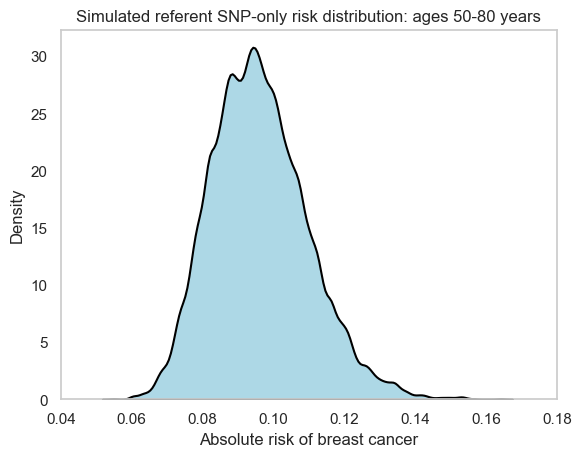

In [10]:
# Density plot of the simulated reference population
sns.kdeplot(reference_risks[0]["population_risks"], bw_adjust=0.5, color="black", fill=True, alpha=0.3, linewidth=1.5, facecolor="lightblue")
plt.xlim(0.04, 0.18)
plt.xlabel("Absolute risk of breast cancer")
plt.title("Simulated referent SNP-only risk distribution: ages 50-80 years")

plt.show()

Now, suppose we want to apply the absolute risk model to predict the risks for three specific women whom we have genotyped information (with some missing SNP values). An example of such a profile is provided at `query_snp_profile.csv`:

In [11]:
apply_snp_profile_path = "../data/query_snp_profile.csv"

We pass this option into iCARE to calculate their risks:

In [12]:
results_with_profiles = icare.compute_absolute_risk(
    apply_age_start=50,
    apply_age_interval_length=30, # 50 + 30 = 80
    model_disease_incidence_rates_path=model_disease_incidence_rates_path,
    model_competing_incidence_rates_path=model_competing_incidence_rates_path,
    model_snp_info_path=model_snp_info_path,
    apply_snp_profile_path=apply_snp_profile_path,
    return_reference_risks=True # return the absolute risks for the simulated reference population
)


Note: You did not provide a 'model_family_history_variable_name', therefore the model will not adjust the SNP imputations for family history.



Now our output `results_with_profiles["profile"]` contains the risk estimates for the three women whose genotype profiles were provided in `apply_snp_profile_path`.

In [13]:
queried_profiles = pd.read_json(results_with_profiles["profile"], orient="records")
queried_profiles

,id,age_interval_start,age_interval_end,risk_estimates,rs616488,rs11552449,rs11249433,rs12405132,rs12048493,rs6678914,...,rs527616,rs1436904,rs6507583,rs4808801,rs3760982,rs2284378,rs2823093,rs17879961,rs132390,rs6001930
0,Q-01,50,80,0.087774,NaN,NaN,NaN,NaN,NaN,0.0,...,0,0,0,1,0,1,1,0,0,0
1,Q-02,50,80,0.103953,2.0,0.0,NaN,NaN,NaN,NaN,...,0,0,0,1,1,1,0,0,0,0
2,Q-03,50,80,0.134265,2.0,0.0,1.0,1.0,1.0,1.0,...,1,1,0,1,1,0,0,0,0,0


In this example, the first genotype profile had missing data on five SNPs. The second genotype profile had missing data on a different set of five SNPs. This demonstrates the capability of iCARE to produce risk estimates when there is missing data in the risk factor profile without compromising on user convenience.

We can plot the estimated risks of the queried profiles and compare them to the risk distribution of the simulated reference population:

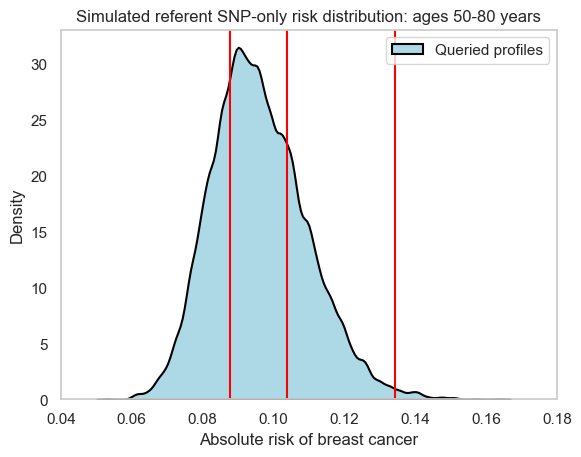

In [14]:
# Density plot of the simulated reference population
sns.kdeplot(results_with_profiles["reference_risks"][0]["population_risks"], bw_adjust=0.5, color="black", fill=True, alpha=0.3, linewidth=1.5, facecolor="lightblue")
plt.xlim(0.04, 0.18)
plt.xlabel("Absolute risk of breast cancer")
plt.title("Simulated referent SNP-only risk distribution: ages 50-80 years")

# Add a vertical red line, one for each queried profile
for risk_value in queried_profiles["risk_estimates"]:
    plt.axvline(risk_value, color="red")

plt.legend(["Queried profiles"], loc="upper right")

plt.show()